# Import modules

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import pytz
import datetime 
import astral
import astropy.time as aptime
import os
import glob

# Read in text files

In [28]:
#txt_file1 = pd.read_csv('IFS_AllOnSky_RawDistorcorr_aotelem_CleanSee30_20190226.txt')
txt_file1= pd.read_csv('IFS_AllOnSky_RawDistorcorr_aotelem_CleanSee30_20190227.txt')
txt_file1_copy = copy.copy(txt_file1)
raw_contrast_data= pd.DataFrame(txt_file1_copy)
print len(raw_contrast_data)

raw_contrast_data['dts'] = aptime.Time(raw_contrast_data['MJDOBS'], format='mjd').datetime 
raw_contrast_data['dts'] = raw_contrast_data['dts'].dt.tz_localize(pytz.UTC)

1310


In [29]:
raw_contrast_data.head()

,IMAG,AOWFE,MJDOBS,COADDS,DATAFILE,OBSMODE,CONTR040,phase_file,OBJNAME,whenstr,TAMBIENT,OMSATEMP,MASSSEE,MASSTAU,DIMMSEE,dts
0,4.65,134.30,56971.152107,1,S20141110S0149.fits,H_coron,0.000081,ugp_When_2014.11.10_0.38.9_phase,HR 789,20141110003809,12.0,13.7188,NaN,NaN,NaN,2014-11-10 03:39:02.036160+00:00
1,4.65,134.30,56971.152107,1,S20141110S0149.fits,H_coron,0.000081,ugp_When_2014.11.10_0.39.7_phase,HR 789,20141110003907,12.0,13.7143,NaN,NaN,NaN,2014-11-10 03:39:02.036160+00:00
2,4.65,129.40,56971.152992,1,S20141110S0150.fits,H_coron,0.000098,ugp_When_2014.11.10_0.40.2_phase,HR 789,20141110004002,12.0,13.7143,NaN,NaN,NaN,2014-11-10 03:40:18.526079+00:00
3,4.65,131.83,56971.153902,1,S20141110S0151.fits,H_coron,0.000086,ugp_When_2014.11.10_0.41.2_phase,HR 789,20141110004102,12.0,13.7143,NaN,NaN,NaN,2014-11-10 03:41:37.158720+00:00
4,4.65,131.83,56971.153902,1,S20141110S0151.fits,H_coron,0.000086,ugp_When_2014.11.10_0.41.49_phase,HR 789,20141110004149,12.0,13.7143,NaN,NaN,NaN,2014-11-10 03:41:37.158720+00:00


In [4]:
txt_file2 = pd.read_csv('AO_telem_20180207.txt')
txt_file2_copy = copy.copy(txt_file2)
ao_telem_data = pd.DataFrame(txt_file2_copy)
print len(ao_telem_data)

ao_telem_data['dts'] = pd.to_datetime(ao_telem_data['whenstr'], utc=True, format = '%Y%m%d%H%M%S')
ao_telem_data['dts'] = ao_telem_data['dts'].dt.tz_convert(pytz.UTC)
ao_telem_data['whenstr'] = ao_telem_data['whenstr'].astype('str')

#phase filename
ao_telem_data['phase_file'] = 'When_' 
ao_telem_data['phase_file'] = ao_telem_data['phase_file'] + ao_telem_data.loc[:,'dts'].dt.strftime('%Y.%-m.%-d_%-H.%-M.%-S')

#phase directory 
ao_telem_data['phase_dir'] = ao_telem_data.loc[:,'whenstr'].str[0:8]

2566


# Merge IFS data with AO telemetry

Fill missing IFS data with nan

In [63]:
ao_telem_raw_IFS_data =  pd.merge_asof(ao_telem_data, raw_contrast_data, by='OBJNAME',on='dts',tolerance=pd.Timedelta('1min'))

In [64]:
print len(ao_telem_raw_IFS_data)
print sum(np.isfinite(ao_telem_raw_IFS_data['MASSTAU']))
print sum(np.isfinite(ao_telem_raw_IFS_data['WFE']))

2566
4
2566


# Output into a list of files

In [4]:
phase_samples = raw_contrast_data.loc[:,'phase_file']
phase_samples = phase_samples.drop_duplicates(keep='first').values
phase_samples = pd.DataFrame({'phase_file':list(phase_samples)})

In [8]:
save_path = '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/datatables/'

In [7]:
phase_samples.to_csv(save_path+'phase_samples_20180226.txt',index=False,header=False)

# Make a list that leaves out filenames already analyzed 

In [9]:
new_phase_samples = raw_contrast_data.loc[:,'phase_file']
new_phase_samples = new_phase_samples.drop_duplicates(keep='first').values

In [12]:
old_phase_samples = pd.read_csv('phase_samples_20181105.txt',header=None)
old_phase_samples = pd.Series(old_phase_samples[0]).values

In [13]:
new_phase_samples.update(old_phase_samples)

AttributeError: 'numpy.ndarray' object has no attribute 'update'

new = set(new_phase_samples)
old = set(old_phase_samples) 

In [ ]:
phase_samples = pd.DataFrame({'phase_file':list(new_phase_samples)})

# Reproduce IFS sample with AO telem data

Fill missing ao telem data with nans

In [32]:
def filter_data(data, imag = 10., tau = 1., see = 2., all_cond = True):
    "This selects all rows of input dataframe that satisfy conditions set by the user"
    
    date1 = datetime.date(year = 2014, month = 1, day =1)
    
    #  AO system requirements
    cond1 = data['dts'] > date1 
    cond2 = data['COADDS'] == 1
    cond3 = (data['OBSMODE'] == 'H_coron')|(data['OBSMODE'] == 'Spec')
    #cond4 = data['AOFRAMES'] == 1000

    #  Good seeing conditions
    cond5 = data['IMAG'] < imag #Bright Stars
    cond6 = data['MASSTAU'] > tau  # slow moving turbulence [ms]
    cond7 = data['DIMMSEE'] < see  # smaller scale turbulence ["]
    
    if all_cond:
        ind = np.where(cond1 & cond2 & cond3 & cond5 & cond6 & cond7)[0]  
        print len(ind)
    else:
        ind = np.where(cond1 & cond2 & cond3 & cond4 & cond5)[0]  
        print len(ind)

    filtered_data = data.iloc[ind]
    #filtered_data = filtered_data.dropna(subset = ['CONTR040','cal_wfe','M1_avg','TAMBIENT','Outside_OE_temperature'])
    
    new_ind = np.arange(len(filtered_data))
    filtered_data = filtered_data.set_index(new_ind)
        
    return filtered_data

In [33]:
r = filter_data(raw_contrast_data,all_cond=True)

282


drop rows missing mass tau measurements and wfe measurements

In [19]:
raw_IFS_ao_telem_data =  pd.merge_asof(r, ao_telem_data, on='dts',tolerance=pd.Timedelta('1min')).dropna(subset=['WFE']).dropna(subset=['MASSTAU']).dropna(subset=['DIMMSEE'])

# Instances of best and worst seeing

In [85]:
ao_telem_raw_IFS_data = ao_telem_raw_IFS_data.dropna(subset=['phase_file','M1_avg','TAMBIENT'])

In [72]:
len(ao_telem_raw_IFS_data)

561

In [12]:
def search_for_dome_seeing(data, sample_size, presence = True):
    
    cut = sample_size
    sample = set()
    
    if presence:
        
        while len(sample) <= sample_size:
            tau0 = data.MASSTAU.sort_values(ascending = False)[0:cut]
            mirror_to_air_temp = np.abs(data.M1_avg - data.T_twr).sort_values(ascending = False)[0:cut]
            contrast = data.CONTR040.sort_values(ascending = False)[0:cut]
            sample = set(tau0.index) & set(mirror_to_air_temp.index) & set(contrast.index)
            cut = cut + 1
            
    else:
        
        while len(sample) <= sample_size:
            tau0 = data.MASSTAU.sort_values(ascending = False)[0:cut]
            mirror_to_air_temp = np.abs(data.M1_avg - data.T_twr).sort_values()[0:cut]
            contrast = data.CONTR040.sort_values()[0:cut]
            sample = set(tau0.index) & set(mirror_to_air_temp.index) & set(contrast.index)
            cut = cut + 1
    return list(sample)  

In [34]:
def search_for_dome_seeing(data, sample_size, presence = True):
    
    cut = sample_size
    sample = set()
    
    if presence:
        
        while len(sample) <= sample_size:
            tau0 = data.MASSTAU.sort_values(ascending = False)[0:cut]
            mirror_to_air_temp = np.abs(data.OMSATEMP - data.TAMBIENT).sort_values(ascending = False)[0:cut]
            contrast = data.CONTR040.sort_values(ascending = False)[0:cut]
            sample = set(tau0.index) & set(mirror_to_air_temp.index) & set(contrast.index)
            cut = cut + 1
            
    else:
        
        while len(sample) <= sample_size:
            tau0 = data.MASSTAU.sort_values(ascending = False)[0:cut]
            mirror_to_air_temp = np.abs(data.OMSATEMP - data.TAMBIENT).sort_values()[0:cut]
            contrast = data.CONTR040.sort_values()[0:cut]
            sample = set(tau0.index) & set(mirror_to_air_temp.index) & set(contrast.index)
            cut = cut + 1
    return list(sample)  

In [54]:
sample = r.loc[search_for_dome_seeing(r,50,presence=False),
                       ['month','OBJNAME','dts','phase_file','CONTR040','OMSATEMP','TAMBIENT','MASSTAU','IMAG']].sort_values("CONTR040",ascending = False)

# Grouping

In [55]:
g = sample.groupby(['month','OBJNAME'])

In [56]:
no_dome_seeing_list = set()
for name,group in g:
    print(name)
    print(group['phase_file'].values,group['OMSATEMP'].values,group['TAMBIENT'].values)
    no_dome_seeing_list.update(group['OBJNAME'].values)

(3, 'HD 149813')
(array(['ugp_When_2016.3.28_6.2.37_phase',
       'ugp_When_2016.3.28_5.52.6_phase', 'ugp_When_2016.3.28_5.52.6_phase'], dtype=object), array([ 14.1607,  14.1473,  14.1473]), array([ 14.,  13.,  13.]))
(3, 'HR 5008')
(array(['ugp_When_2016.3.23_2.43.4_phase'], dtype=object), array([ 15.5982]), array([ 15.]))
(9, '42 Cap')
(array(['ugp_When_2016.9.17_23.28.43_phase',
       'ugp_When_2016.9.17_23.18.35_phase'], dtype=object), array([ 13.3973,  13.3616]), array([ 13.,  13.]))
(9, 'EP Eri')
(array(['ugp_When_2016.9.20_5.22.10_phase',
       'ugp_When_2016.9.20_4.58.26_phase',
       'ugp_When_2016.9.20_4.55.22_phase',
       'ugp_When_2016.9.20_5.37.16_phase'], dtype=object), array([ 16.3616,  16.3795,  16.3795,  16.3661]), array([ 15.,  15.,  15.,  15.]))
(9, 'HD 11351')
(array(['ugp_When_2016.9.22_3.3.40_phase'], dtype=object), array([ 15.067]), array([ 13.]))
(9, 'HD 16699 A')
(array(['ugp_When_2016.9.19_5.3.6_phase', 'ugp_When_2016.9.19_5.9.46_phase',
       'ugp_When

In [159]:
sample_list = pd.DataFrame({'phase_file':list(sample_list)})

In [160]:
sample_list.to_csv(save_path+'clean_seeing_phase_samples_20190205.txt',index=False,header=False)

# Debugging

In [53]:
dome_seeing_list

{'HD 100546',
 'HD 11351',
 'HD 206893',
 'HD 25953',
 'HD 3821 A',
 'HD 38397',
 'HD 58192',
 'HD 61033',
 'HD 984',
 'HR 4597',
 'HR 8799',
 'HR 9001',
 'NX Aqr',
 'V478 Hya',
 'V592 Pup',
 'c Eri',
 'pi01 Ori'}

In [57]:
no_dome_seeing_list

{'42 Cap',
 'EP Eri',
 'HD 11351',
 'HD 149813',
 'HD 16699 A',
 'HD 200968 A',
 'HD 206893',
 'HD 30447',
 'HD 8558',
 'HR 1139',
 'HR 5008',
 'V834 Tau',
 'c Eri',
 'iot Del',
 'omi Cap B'}

In [58]:
dome_seeing_list.intersection(no_dome_seeing_list)

{'HD 11351', 'HD 206893', 'c Eri'}

In [68]:
c_eri = r.iloc[np.where(r['OBJNAME']=='c Eri')]

<IPython.core.display.Javascript object>


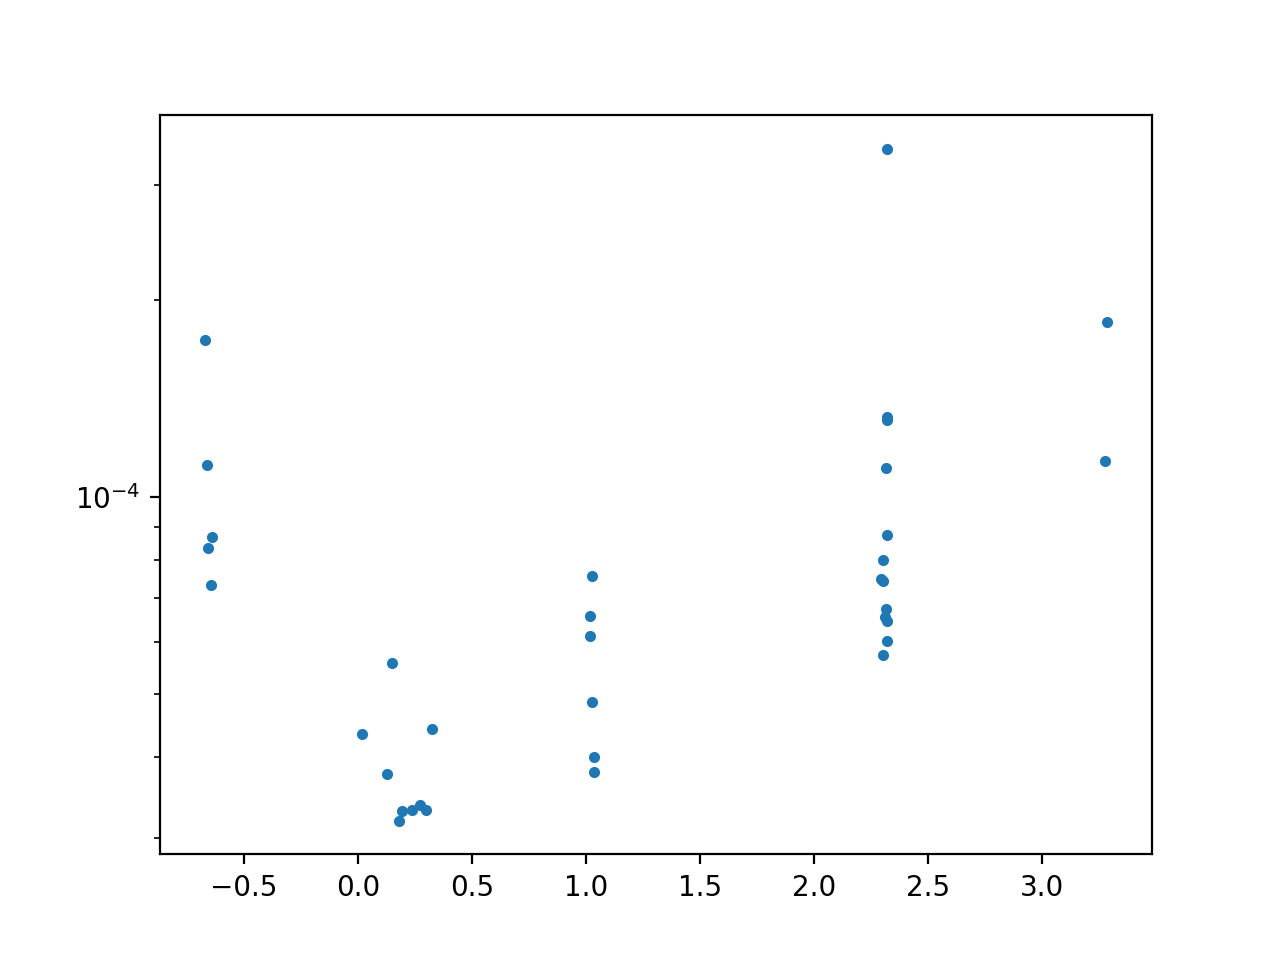

In [69]:
%matplotlib notebook

plt.figure(1)
plt.plot(c_eri['OMSATEMP']-c_eri['TAMBIENT'],c_eri['CONTR040'],'.')
plt.yscale('log')

In [89]:
aotelem = pd.read_csv('aotelem_20190226.txt')

In [105]:
Eri_list =list(aotelem.loc[np.where(aotelem['objname']=='c Eri')[0],'datafile'])

In [155]:
result = [re.search('ugp_(.*)_phase', n).group(1) for n in Eri_list]

In [156]:
result = set(result)

In [117]:
sample_list = pd.DataFrame({'phase_file':list(result)})
sample_list.to_csv(save_path+'c_Eri_samples.txt',index=False,header=False)

In [148]:
l1 = set(pd.read_csv(save_path+'phase_samples_20181116.txt',header=None)[0].values)
l2 = set(pd.read_csv(save_path+'phase_samples_20181116.txt',header=None)[0].values)
l3 = set(pd.read_csv(save_path+'phase_samples_20181116.txt',header=None)[0].values)

In [157]:
l123=set()
l123.update(l1)
l123.update(l2)
l123.update(l3)

In [144]:
l123.intersection_update(set(result))

In [153]:
s = result &= l123